In [6]:
import torch
from torchvision import transforms

from models import coders
from data.datasets import AutoImageData

from data.utils import loaders

In [7]:
torch.__version__

'1.13.0'

In [8]:
xforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.CenterCrop(224)
])

dataset = AutoImageData(root="../test_data", loader=loaders.image_loader, input_transform=xforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
print(dataset)

hi
Dataset AutoImageData
    Number of datapoints: 1
    Root location: ../test_data
    Compose(
    PILToTensor()
    CenterCrop(size=(224, 224))
)


In [9]:
autoencoder = coders.ConvAutoEncoder(num_classes=3)

  0%|          | 0/50 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(17.9374, device='cuda:0', grad_fn=<AmaxBackward0>)
Epoch 0:  U-Net Training loss: None


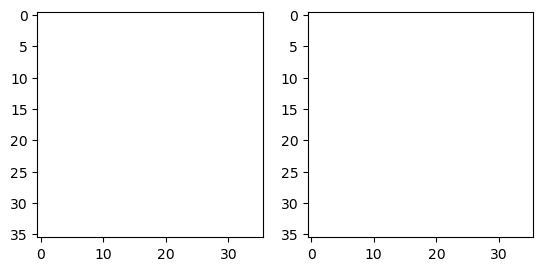

  4%|▍         | 2/50 [00:01<00:24,  1.93it/s]

tensor(96.0607, device='cuda:0', grad_fn=<AmaxBackward0>)


  6%|▌         | 3/50 [00:01<00:22,  2.11it/s]

tensor(67146.0391, device='cuda:0', grad_fn=<AmaxBackward0>)


  8%|▊         | 4/50 [00:01<00:20,  2.20it/s]

tensor(156.6266, device='cuda:0', grad_fn=<AmaxBackward0>)


 10%|█         | 5/50 [00:02<00:20,  2.22it/s]

tensor(60.2978, device='cuda:0', grad_fn=<AmaxBackward0>)


 12%|█▏        | 6/50 [00:02<00:19,  2.23it/s]

tensor(34.8973, device='cuda:0', grad_fn=<AmaxBackward0>)


 14%|█▍        | 7/50 [00:03<00:18,  2.29it/s]

tensor(23.5041, device='cuda:0', grad_fn=<AmaxBackward0>)


 16%|█▌        | 8/50 [00:03<00:18,  2.26it/s]

tensor(17.4404, device='cuda:0', grad_fn=<AmaxBackward0>)


 18%|█▊        | 9/50 [00:04<00:17,  2.28it/s]

tensor(12.7255, device='cuda:0', grad_fn=<AmaxBackward0>)


 20%|██        | 10/50 [00:04<00:18,  2.19it/s]

tensor(9.5443, device='cuda:0', grad_fn=<AmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7.5671, device='cuda:0', grad_fn=<AmaxBackward0>)
Epoch 10:  U-Net Training loss: 51411.63671875


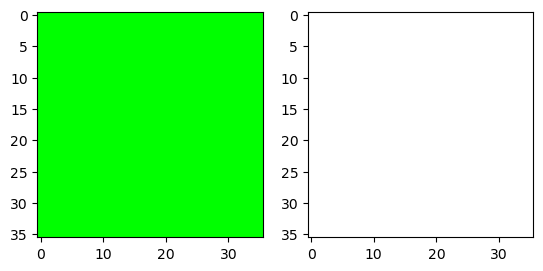

 24%|██▍       | 12/50 [00:05<00:18,  2.00it/s]

tensor(5.8311, device='cuda:0', grad_fn=<AmaxBackward0>)


 26%|██▌       | 13/50 [00:06<00:17,  2.09it/s]

tensor(4.5869, device='cuda:0', grad_fn=<AmaxBackward0>)


 28%|██▊       | 14/50 [00:06<00:18,  1.97it/s]

tensor(6.6303, device='cuda:0', grad_fn=<AmaxBackward0>)


 30%|███       | 15/50 [00:07<00:16,  2.13it/s]

tensor(5.8994, device='cuda:0', grad_fn=<AmaxBackward0>)


 32%|███▏      | 16/50 [00:07<00:15,  2.19it/s]

tensor(8.2880, device='cuda:0', grad_fn=<AmaxBackward0>)


 34%|███▍      | 17/50 [00:07<00:14,  2.25it/s]

tensor(11.8182, device='cuda:0', grad_fn=<AmaxBackward0>)


 36%|███▌      | 18/50 [00:08<00:13,  2.30it/s]

tensor(17.3581, device='cuda:0', grad_fn=<AmaxBackward0>)


 38%|███▊      | 19/50 [00:08<00:13,  2.30it/s]

tensor(24.4349, device='cuda:0', grad_fn=<AmaxBackward0>)


 40%|████      | 20/50 [00:09<00:12,  2.32it/s]

tensor(33.6222, device='cuda:0', grad_fn=<AmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(142.5490, device='cuda:0', grad_fn=<AmaxBackward0>)
Epoch 20:  U-Net Training loss: 44486.8046875


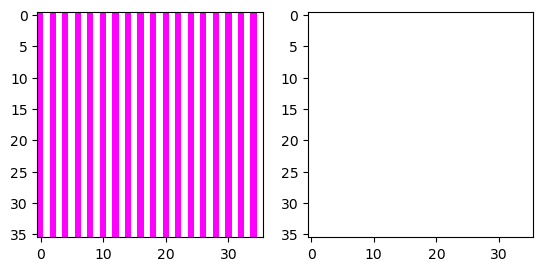

 44%|████▍     | 22/50 [00:10<00:12,  2.18it/s]

tensor(536.6813, device='cuda:0', grad_fn=<AmaxBackward0>)


 46%|████▌     | 23/50 [00:10<00:13,  2.03it/s]

tensor(225.5626, device='cuda:0', grad_fn=<AmaxBackward0>)


 48%|████▊     | 24/50 [00:11<00:13,  1.99it/s]

tensor(162.3952, device='cuda:0', grad_fn=<AmaxBackward0>)


 50%|█████     | 25/50 [00:11<00:11,  2.13it/s]

tensor(183.4102, device='cuda:0', grad_fn=<AmaxBackward0>)


 52%|█████▏    | 26/50 [00:12<00:10,  2.23it/s]

tensor(299.6038, device='cuda:0', grad_fn=<AmaxBackward0>)


 54%|█████▍    | 27/50 [00:12<00:10,  2.27it/s]

tensor(496.3392, device='cuda:0', grad_fn=<AmaxBackward0>)


 56%|█████▌    | 28/50 [00:12<00:09,  2.32it/s]

tensor(235.3545, device='cuda:0', grad_fn=<AmaxBackward0>)


 58%|█████▊    | 29/50 [00:13<00:09,  2.29it/s]

tensor(143.9479, device='cuda:0', grad_fn=<AmaxBackward0>)


 60%|██████    | 30/50 [00:13<00:08,  2.27it/s]

tensor(124.3340, device='cuda:0', grad_fn=<AmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(125.1130, device='cuda:0', grad_fn=<AmaxBackward0>)
Epoch 30:  U-Net Training loss: 15416.2919921875


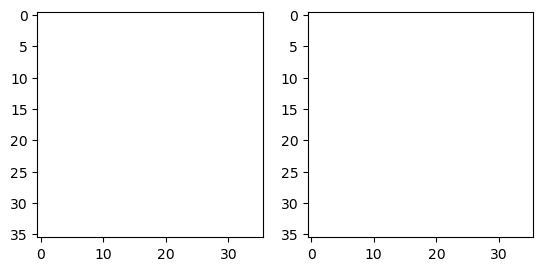

 64%|██████▍   | 32/50 [00:14<00:08,  2.08it/s]

tensor(139.1828, device='cuda:0', grad_fn=<AmaxBackward0>)


 66%|██████▌   | 33/50 [00:15<00:07,  2.17it/s]

tensor(172.8960, device='cuda:0', grad_fn=<AmaxBackward0>)


 68%|██████▊   | 34/50 [00:15<00:07,  2.16it/s]

tensor(236.5446, device='cuda:0', grad_fn=<AmaxBackward0>)


 70%|███████   | 35/50 [00:16<00:06,  2.20it/s]

tensor(342.1503, device='cuda:0', grad_fn=<AmaxBackward0>)


 72%|███████▏  | 36/50 [00:16<00:06,  2.19it/s]

tensor(369.5062, device='cuda:0', grad_fn=<AmaxBackward0>)


 74%|███████▍  | 37/50 [00:17<00:05,  2.20it/s]

tensor(295.7172, device='cuda:0', grad_fn=<AmaxBackward0>)


 76%|███████▌  | 38/50 [00:17<00:05,  2.00it/s]

tensor(233.9622, device='cuda:0', grad_fn=<AmaxBackward0>)


 78%|███████▊  | 39/50 [00:18<00:05,  2.15it/s]

tensor(205.5555, device='cuda:0', grad_fn=<AmaxBackward0>)


 80%|████████  | 40/50 [00:18<00:04,  2.22it/s]

tensor(196.9372, device='cuda:0', grad_fn=<AmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(203.5411, device='cuda:0', grad_fn=<AmaxBackward0>)
Epoch 40:  U-Net Training loss: 4628.20263671875


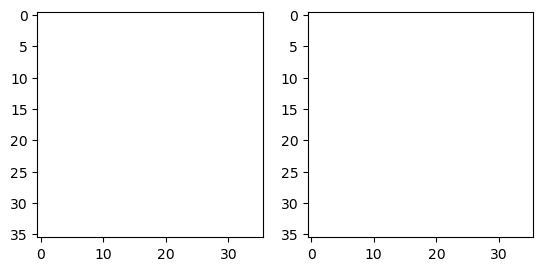

 84%|████████▍ | 42/50 [00:19<00:03,  2.08it/s]

tensor(213.5484, device='cuda:0', grad_fn=<AmaxBackward0>)


 86%|████████▌ | 43/50 [00:20<00:03,  2.13it/s]

tensor(229.5566, device='cuda:0', grad_fn=<AmaxBackward0>)


 88%|████████▊ | 44/50 [00:20<00:02,  2.16it/s]

tensor(250.8787, device='cuda:0', grad_fn=<AmaxBackward0>)


 90%|█████████ | 45/50 [00:21<00:02,  2.02it/s]

tensor(275.1592, device='cuda:0', grad_fn=<AmaxBackward0>)


 92%|█████████▏| 46/50 [00:21<00:01,  2.01it/s]

tensor(298.3130, device='cuda:0', grad_fn=<AmaxBackward0>)


 94%|█████████▍| 47/50 [00:21<00:01,  2.14it/s]

tensor(312.9414, device='cuda:0', grad_fn=<AmaxBackward0>)


 96%|█████████▌| 48/50 [00:22<00:00,  2.17it/s]

tensor(313.0377, device='cuda:0', grad_fn=<AmaxBackward0>)


 98%|█████████▊| 49/50 [00:22<00:00,  2.22it/s]

tensor(299.9897, device='cuda:0', grad_fn=<AmaxBackward0>)


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]

tensor(280.6894, device='cuda:0', grad_fn=<AmaxBackward0>)


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = coders.train(device, autoencoder, epochs=50, lr=0.001, train_loader=dataloader, display_freq=10)